In [1]:
outdir = '../output'

In [2]:
import plot_tools as pt
import data_tools as dt

In [3]:
%matplotlib inline

### Load Data

In [4]:
df_int = dt.load_country()

In [5]:
df_usa = dt.load_state()

In [6]:
df_cnt = dt.load_county()

### Countries

In [8]:
int_names = {
    'USA': 'USA',
    'ITA': 'Italy',
    'KOR': 'Korea',
    'DEU': 'Germany',
    'ESP': 'Spain',
    'CAN': 'Canada'
}
int_codes = list(int_names)
int_sel = df_int.loc[int_codes].unstack(level='country_code')

/home/doug/.local/lib/python3.8/site-packages/matplotlib/scale.py:144: RuntimeWarning: divide by zero encountered in log
  return self._forward(values)


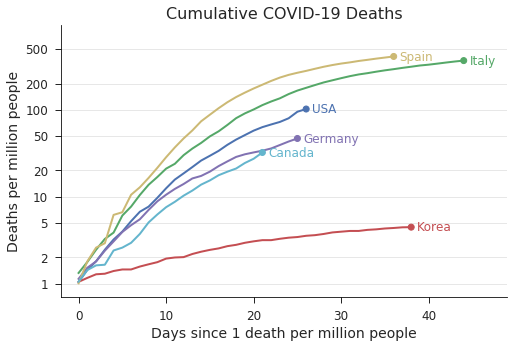

In [9]:
fig, ax = pt.plot_aligned(int_names, data=int_sel['deaths_pc'], start=1e-6)
ax.set_xlabel(f'Days since 1 death per million people')
ax.set_ylabel(f'Deaths per million people')
ax.set_title(f'Cumulative COVID-19 Deaths')
fig.savefig(f'{outdir}/country_deaths.svg', bbox_inches='tight')

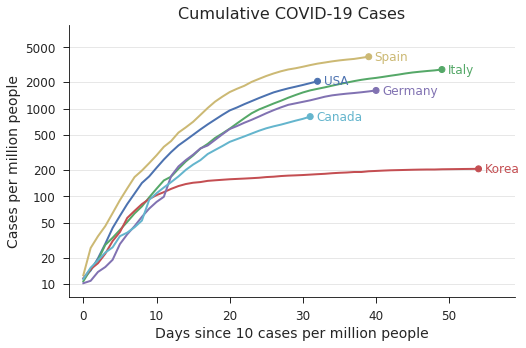

In [10]:
fig, ax = pt.plot_aligned(int_names, data=int_sel['cases_pc'], start=1e-5)
ax.set_xlabel(f'Days since 10 cases per million people')
ax.set_ylabel(f'Cases per million people')
ax.set_title(f'Cumulative COVID-19 Cases')
fig.savefig(f'{outdir}/country_cases.svg', bbox_inches='tight')

### States

In [11]:
usa_names = ['NY', 'CA', 'PA', 'TX', 'IL', 'WA']
usa_sel = df_usa.loc[usa_names].unstack(level='abbrev')

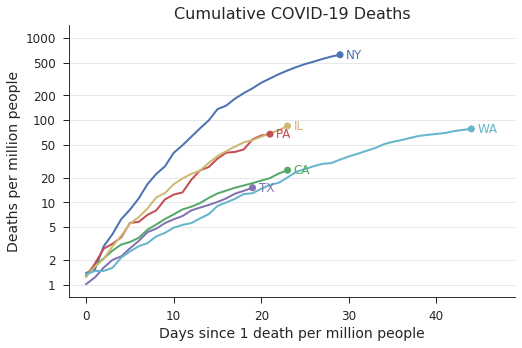

In [12]:
fig, ax = pt.plot_aligned(usa_names, data=usa_sel['deaths_pc'], start=1e-6)
ax.set_xlabel(f'Days since 1 death per million people')
ax.set_ylabel(f'Deaths per million people')
ax.set_title(f'Cumulative COVID-19 Deaths')
fig.savefig(f'{outdir}/state_deaths.svg', bbox_inches='tight')

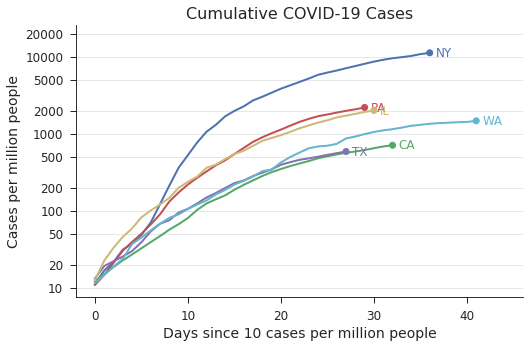

In [13]:
fig, ax = pt.plot_aligned(usa_names, data=usa_sel['cases_pc'], start=1e-5)
ax.set_xlabel(f'Days since 10 cases per million people')
ax.set_ylabel(f'Cases per million people')
ax.set_title(f'Cumulative COVID-19 Cases')
fig.savefig(f'{outdir}/state_cases.svg', bbox_inches='tight')

### Counties

In [14]:
cnt_names = {
    'NYC': 'New York, NY',
    '06037': 'Los Angeles, CA',
    '42003': 'Allegheny, PA',
    '36029': 'Erie, NY',
    '53033': 'King, WA'
}
cnt_codes = list(cnt_names)
cnt_sel = df_cnt.loc[cnt_codes].unstack(level='fips')

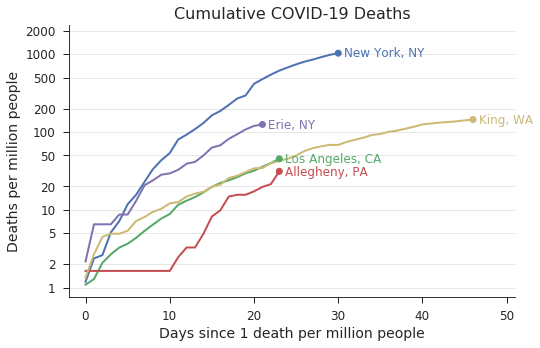

In [15]:
fig, ax = pt.plot_aligned(cnt_names, data=cnt_sel['deaths_pc'], start=1e-6)
ax.set_xlabel(f'Days since 1 death per million people')
ax.set_ylabel(f'Deaths per million people')
ax.set_title(f'Cumulative COVID-19 Deaths')
fig.savefig(f'{outdir}/county_deaths.svg', bbox_inches='tight')

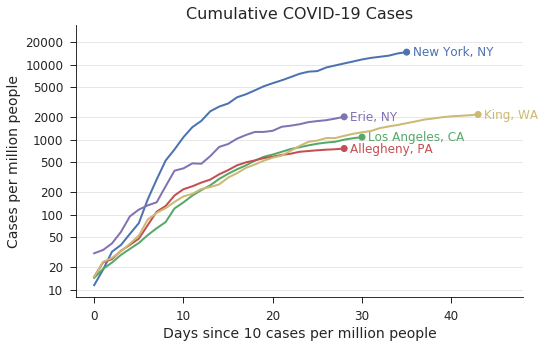

In [16]:
fig, ax = pt.plot_aligned(cnt_names, data=cnt_sel['cases_pc'], start=1e-5)
ax.set_xlabel(f'Days since 10 cases per million people')
ax.set_ylabel(f'Cases per million people')
ax.set_title(f'Cumulative COVID-19 Cases')
fig.savefig(f'{outdir}/county_cases.svg', bbox_inches='tight')